In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import itertools    
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Read images

Total no of images = 5305


<BarContainer object of 10 artists>

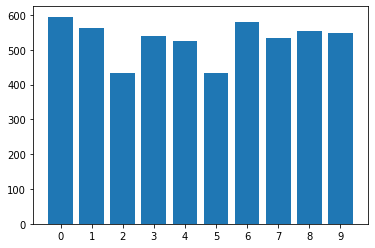

In [2]:
import pathlib

data_dir = pathlib.Path('./dataset')


image_count = len(list(data_dir.glob('*/*.*')))
print("Total no of images =", image_count)

images = []
labels = []
for item in data_dir.glob('*'):
    labels.append(str(item).split('/')[-1])
    images.append(len(list(item.glob('*'))))
    
images = [i for l, i in sorted(zip(labels, images))]
labels.sort()
plt.bar(labels, images)


## Split data

In [3]:


batch_size = 64
img_height = 100
img_width = 100



In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5304 files belonging to 10 classes.
Using 4774 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5304 files belonging to 10 classes.
Using 1060 files for validation.


In [6]:
class_names = train_ds.class_names

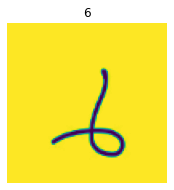

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
num_classes = 10
img_channels = 1

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height, img_width, img_channels)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  #keras.layers.Dense(num_classes, activation='softmax')
])

In [9]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0

In [11]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
75/75 [==============================] - 15s 199ms/step - loss: 20.8756 - accuracy: 0.1660 - val_loss: 1.1381 - val_accuracy: 0.6245
Epoch 2/15
75/75 [==============================] - 20s 263ms/step - loss: 1.1313 - accuracy: 0.6324 - val_loss: 0.6007 - val_accuracy: 0.8132
Epoch 3/15
75/75 [==============================] - 19s 258ms/step - loss: 0.5287 - accuracy: 0.8263 - val_loss: 0.3405 - val_accuracy: 0.8981
Epoch 4/15
75/75 [==============================] - 20s 262ms/step - loss: 0.2878 - accuracy: 0.9071 - val_loss: 0.3054 - val_accuracy: 0.9170
Epoch 5/15
75/75 [==============================] - 20s 258ms/step - loss: 0.1954 - accuracy: 0.9331 - val_loss: 0.3051 - val_accuracy: 0.9198
Epoch 6/15
75/75 [==============================] - 19s 256ms/step - loss: 0.1327 - accuracy: 0.9553 - val_loss: 0.2711 - val_accuracy: 0.9264
Epoch 7/15
75/75 [==============================] - 19s 255ms/step - loss: 0.1077 - accuracy: 0.9688 - val_loss: 0.2724 - val_accuracy: 0.933

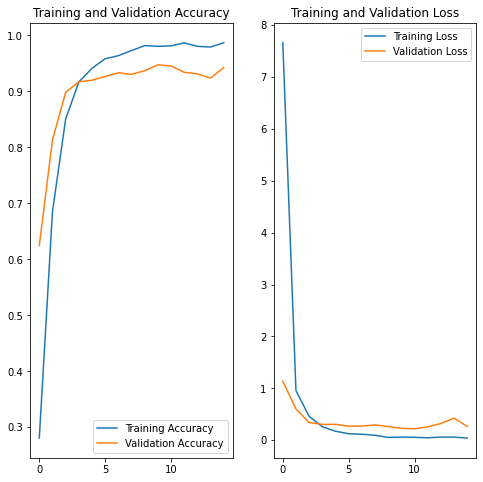

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


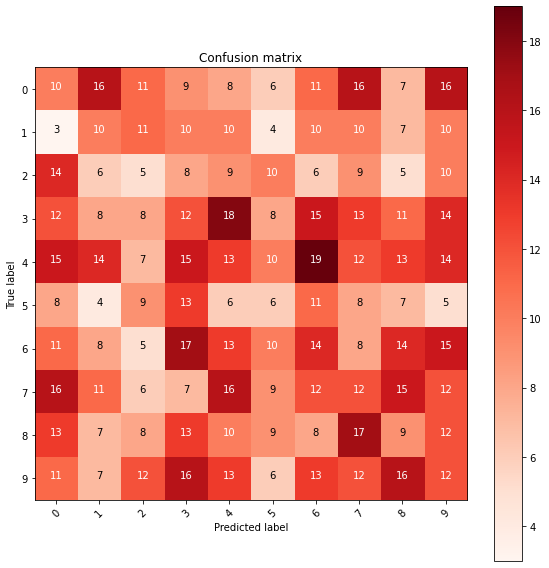

In [17]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  # Compute the labels from the normalized confusion matrix.
  labels = cm# np.around(cm.astype('float') / cm.sum(axis=0)[np.newaxis, :], decimals=2)
    
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(labels, interpolation='nearest', cmap=plt.cm.Reds)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  

  # Use white text if squares are dark; otherwise black.
  threshold = labels.max() / 2.
  for i, j in itertools.product(range(labels.shape[0]), range(labels.shape[1])):
    color = "white" if labels[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

y_pred = model.predict(val_ds)
#y_pred = tf.nn.softmax(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)
figure = plot_confusion_matrix(cm, class_names)

In [15]:
 test_image_path = "eq.png"

 img = keras.preprocessing.image.load_img(
     test_image_path, target_size=(img_height, img_width), color_mode="grayscale"
 )
 img_array = keras.preprocessing.image.img_to_array(img)
 img_array = tf.expand_dims(img_array, 0)  #Create a batch

 predictions = model.predict(img_array)
 score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 4 with a 99.60 percent confidence.
